# 1. Introdução
 
Nesse NOTEBOOK encontra-se o código utilizado para aplicar a técnica de *Transfer Learning* com objetivo de aproveitar a capacidade de extração de features de animais da rede MobileNet somada a uma nova camada *fully connected* para classificação de gatos específicos de uma casa.

# 2. Parâmetros e Caminho das Imagens


In [ ]:
classes = ["NENHUM", "PESSOA"]

base_path = r"C:\Users\\mateu\\Documents\\workdir\\mba\\robotics\\people-detector\\human-and-non-human\\training_set"

EPOCHS = 40

BATCH_SIZE = 100

DIM = 96

# 3. Preparação dos Dados

# 3.1. Carga do Dataset


In [2]:
import cv2

def load_image(image_path):

    image = cv2.imread(image_path)
    image = cv2.resize(image, (DIM, DIM))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image


In [3]:
import os
import numpy as np


def load_dataset(base_path, classes):

    data = []
    labels = []

    os.chdir(base_path)


    for i in range(len(classes)):
        path = base_path+"/"+classes[i]

        j = 0
        with os.scandir(path) as files:

            for file in files:

                try:

                    image = load_image(file.path)

                    if image.shape[0] >= DIM:
                        data.append(image)
                        labels.append(i)
                        
                except:
                    pass

    data = np.array(data, dtype="float32") / 255.0
    labels = np.array(labels)

    return data, labels

In [4]:

data, labels = load_dataset(base_path, classes)

print(data.shape)
print(labels.shape)

(8017, 96, 96, 3)
(8017,)


# 3.2. Categorização

In [7]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_features, validation_features, train_labels, validation_labels = train_test_split(data, labels, test_size=0.2, random_state=0)

print('# of training images:', train_features.shape[0])
print('# of cross-validation images:', validation_features.shape[0])

X_train, y_train = train_features, train_labels
X_validation, y_validation = validation_features, validation_labels


# of training images: 6413
# of cross-validation images: 1604


# 3.3. Data Augmentation

In [8]:
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range=0.1,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=False, 
)  

train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)


# 4. Modelagem

# 4.1. Modelo Base

In [9]:
from tensorflow import keras

base_model = keras.applications.MobileNet(
    weights='imagenet',
    input_shape=(DIM, DIM, 3),
    alpha=0.25,
    include_top=False
    )

base_model.trainable = False

base_model.summary()
    

C:\Users\mateu\AppData\Local\Temp\ipykernel_3432\2243921593.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNet(


2108140/2108140 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenet_0.25_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 8)      │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 48, 48, 8)      │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 48, 48, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 48, 48, 16)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 49, 49, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 24, 24, 16)     │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 24, 24, 32)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 24, 24, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 24, 24, 32)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 218,544 (853.69 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 218,544 (853.69 KB)

# 4.2. Classificacor Específico

In [10]:
import tensorflow as tf

base_model.trainable = False

last_layer = base_model.get_layer('conv_pw_10_relu')

#x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(last_layer.output)
x = tf.keras.layers.Reshape((-1, last_layer.output.shape[3]))(last_layer.output)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=len(classes), activation='softmax')(x)

model = tf.keras.Model(base_model.input, x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 8)      │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 48, 48, 8)      │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 48, 48, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 48, 48, 16)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 49, 49, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 24, 24, 16)     │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 24, 24, 32)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 24, 24, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 24, 24, 32)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 103,858 (405.70 KB)

 Trainable params: 9,218 (36.01 KB)

 Non-trainable params: 94,640 (369.69 KB)

# 5. Treinamento

In [11]:
import tensorflow

steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_validation.shape[0] // BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
          validation_data=validation_generator, validation_steps=validation_steps,
          shuffle=True)

c:\Users\mateu\Documents\workdir\mba\robotics\FIAP-RIOT-7DTSR\AULA04\4.people_detector\people_detector\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.7249 - loss: 0.9468 - val_accuracy: 0.9825 - val_loss: 0.0469
Epoch 2/40
 1/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9600 - loss: 0.1295

c:\Users\mateu\Documents\workdir\mba\robotics\FIAP-RIOT-7DTSR\AULA04\4.people_detector\people_detector\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9600 - loss: 0.1295 - val_accuracy: 0.9837 - val_loss: 0.0455
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9632 - loss: 0.0950 - val_accuracy: 0.9950 - val_loss: 0.0195
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.9950 - val_loss: 0.0195
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9843 - loss: 0.0540 - val_accuracy: 0.9969 - val_loss: 0.0130
Epoch 6/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0207 - val_accuracy: 0.9969 - val_loss: 0.0132
Epoch 7/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9899 - loss: 0.0332 - val_accuracy: 0.9987 - val_loss: 0.0085
Epoch 8/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9900 - loss: 0.0395 - val_accuracy: 0.9987 - val_loss: 0.0085
Epoch 9/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9877 - loss: 0.0323 - val_accuracy: 0.9994 - val_loss: 

# 5.1. Desempenho

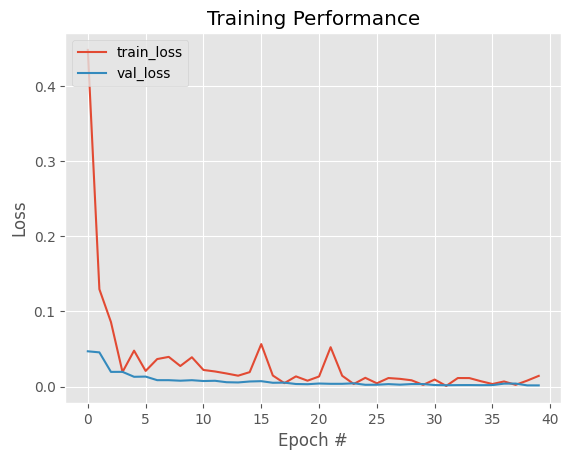

In [12]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

plt.title("Training Performance")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

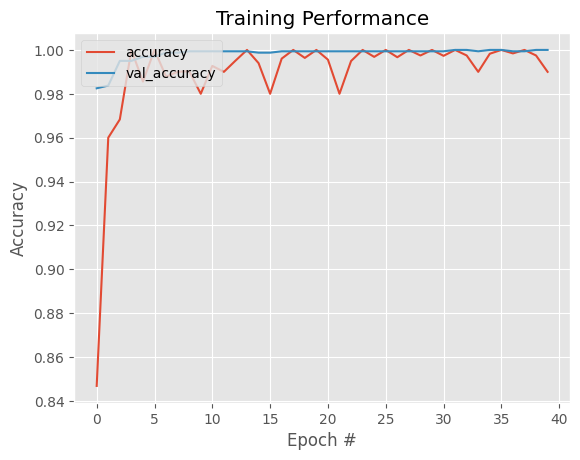

In [13]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")

plt.title("Training Performance")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

# 5.2. Nota Final

In [14]:
print("Evaluate on test data")
model.evaluate(X_validation, y_validation, batch_size=BATCH_SIZE)

Evaluate on test data
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0014


[0.001519596902653575, 1.0]

# 6. Fine Tuning

In [15]:

base_model.trainable = True

model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.000045),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=int(EPOCHS/2),
          validation_data=validation_generator, validation_steps=validation_steps,
          shuffle=True)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - accuracy: 0.9658 - loss: 0.0854 - val_accuracy: 0.9969 - val_loss: 0.0082
Epoch 2/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.9900 - loss: 0.0279

c:\Users\mateu\Documents\workdir\mba\robotics\FIAP-RIOT-7DTSR\AULA04\4.people_detector\people_detector\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9900 - loss: 0.0279 - val_accuracy: 0.9969 - val_loss: 0.0082
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.9971 - loss: 0.0142 - val_accuracy: 0.9981 - val_loss: 0.0058
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 0.9981 - val_loss: 0.0058
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - accuracy: 0.9954 - loss: 0.0137 - val_accuracy: 0.9994 - val_loss: 0.0042
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0040
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.9958 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.9989 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss

# 6.1. Desempenho

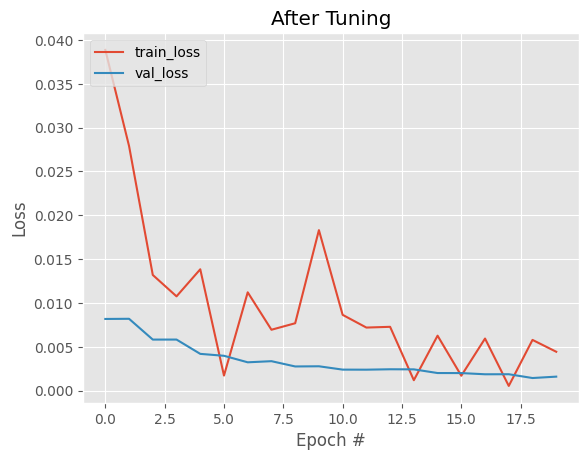

In [16]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
N = int(EPOCHS/2)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

plt.title("After Tuning")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

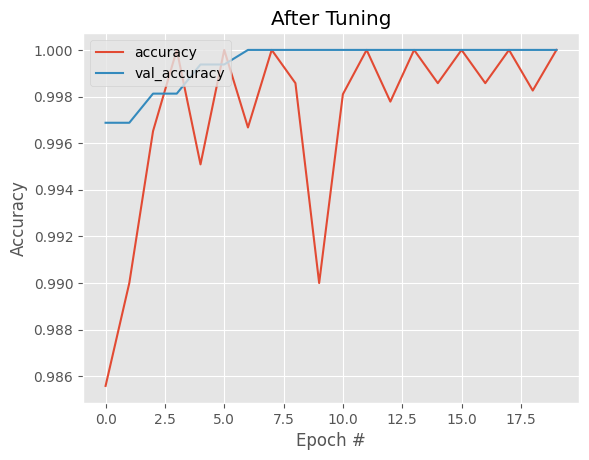

In [17]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
N = int(EPOCHS/2)
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")

plt.title("After Tuning")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

# 6.2. Nota Final

In [18]:
print("Evaluate on test data")
_, model_accuracy = model.evaluate(X_validation, y_validation, batch_size=BATCH_SIZE)

Evaluate on test data
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0015


# 7. Conversão

# 7.1. Modelo Final Sem Conversão

Para uso em testes posteriores.

In [19]:
tf.keras.models.save_model(
    model, base_path+"/home-people-train-model.h5", overwrite=True, include_optimizer=True
)


# 7.2. Método Auxiliar

In [20]:
def representative_dataset_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(data).batch(1).take(BATCH_SIZE):
    
    yield [input_value]

# 7.3. Quantização e Persistência

In [ ]:
# import tensorflow as tf

# # Load the model
# model = tf.keras.models.load_model(base_path + "/home-people-train-model.h5")

# # Check model summary
# model.summary()

In [21]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.allow_custom_ops = True


converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]

converter.inference_input_type = tf.int8 
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

open(base_path+'/home-people-train-model.tflite', "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\mateu\AppData\Local\Temp\tmpnnxp9zx5\assets


INFO:tensorflow:Assets written to: C:\Users\mateu\AppData\Local\Temp\tmpnnxp9zx5\assets


Saved artifact at 'C:\Users\mateu\AppData\Local\Temp\tmpnnxp9zx5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2337896437072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896438224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896438608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896437840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896436112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896438416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896438032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896436688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896439184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896436880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2337896

c:\Users\mateu\Documents\workdir\mba\robotics\FIAP-RIOT-7DTSR\AULA04\4.people_detector\people_detector\.venv\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


156784

# 7.4. Avaliação do Modelo Convertido

In [22]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(data):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))

    test_image = np.array(test_image*255-128, dtype="int8")
    test_image = test_image.reshape(1,DIM,DIM,3)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == labels).mean()
  return accuracy

In [23]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.


Quant TFLite test_accuracy: 0.9997505301234876
